In [140]:
from numpy import linspace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats.kde import gaussian_kde

from palettable.matplotlib import Magma_10
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlOrRd_6
from palettable.colorbrewer.sequential import GnBu_8
from palettable.colorbrewer.sequential import OrRd_6
from palettable.colorbrewer.diverging import PuOr_7
from palettable.cartocolors.sequential import PurpOr_6
from palettable.cartocolors.sequential import RedOr_6
from palettable.cartocolors.qualitative import Vivid_4
from palettable.colorbrewer.qualitative import Dark2_4

from ideotype.data_process import (read_data,
                                   fetch_norm_mean_disp,
                                   fetch_mean_disp_diff,
                                   fetch_sim_values)
from ideotype.analysis import (rank_top_phenos, 
                               identify_top_phenos,
                               identify_improved_phenos, 
                               phenostage_climate)
from ideotype.figures import (plot_rankchange,
                              plot_params_heatmap,
                              plot_cspace_rank,
                              plot_cspace_yield,
                              plot_mean_disp_change)
from ideotype.init_params import params_sample
from ideotype.data_process import parse_mature
from ideotype import DATA_PATH

In [3]:
# Read in data etc.
run_name = 'present'
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all)
df_all.drop(df_stuck.index, inplace=True)
df_all.site = df_all.site.astype(int)
df_wea.site = df_wea.site.astype(int)

In [4]:
# Read in data for future sims
run_name = 'f2100'
df_sims, df_sites, df_wea, df_params, df_all_f2100, df_matured = read_data(
    f'/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_{run_name}.yml')
df_extended, df_stuck = parse_mature(df_all_f2100)
df_all_f2100.drop(df_stuck.index, inplace=True)

## Relationship between yield & climate

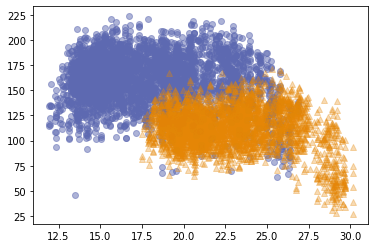

In [33]:
phenos = phenogroups[1]
df_sub = df_all[df_all.cvar.isin(phenos)]
plt.scatter(df_sub.temp, df_sub.dm_ear, 
            color=colors[0], alpha=0.5)
df_sub = df_all_f2100[df_all_f2100.cvar.isin(phenos)]
plt.scatter(df_sub.temp, df_sub.dm_ear, 
            color=colors[1], marker='^', alpha=0.3)

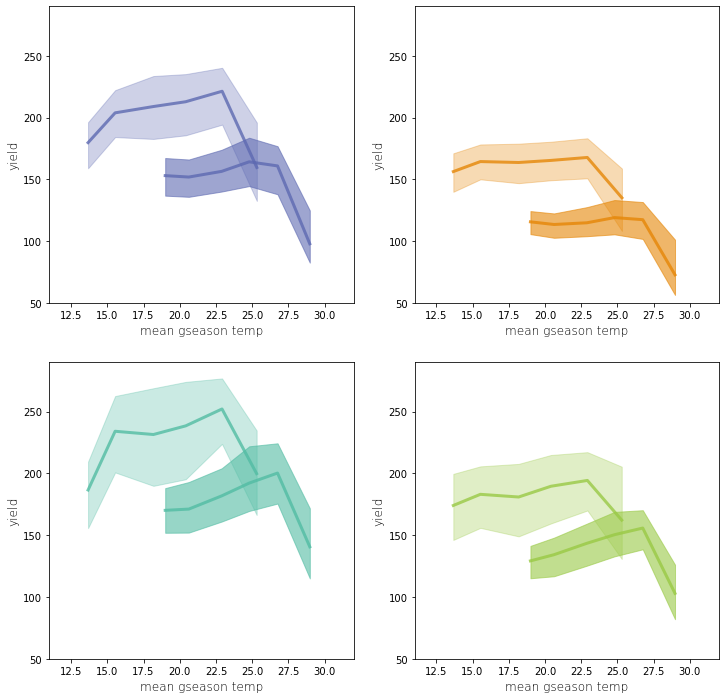

In [5]:
# set up colors
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
colors = [c1,c2,c3,c4]

# set up temp bins
n_bins = 6
phenogroups = [[4,65,46], [44,58,62], [88,9], [5]]

# visualization
fig = plt.figure(figsize=(12,12))

for pos, (phenos, c) in enumerate(zip(phenogroups, colors)):
    ax = fig.add_subplot(2,2,pos+1)
    ax.set_xlim(11,32)
    ax.set_ylim((50,290))
    ax.set_xlabel('mean gseason temp', fontweight='light', fontsize=12)
    ax.set_ylabel('yield', fontweight='light', fontsize=12)
    df_s = df_all[df_all.cvar.isin(phenos)]
    bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
    df_sub = df_s.copy()
    df_sub.loc[:,'bins'] = bins
    upper_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 75),2) for item in np.arange(n_bins)]
    mid_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 50),2) for item in np.arange(n_bins)]
    lower_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 25),2) for item in np.arange(n_bins)]
    temp_means = df_sub.groupby('bins').mean().temp
    ax.plot(temp_means, mid_yield, color=c, linewidth=3, alpha=0.8)
    ax.fill_between(temp_means, upper_yield, lower_yield,
                     color=c, alpha=0.3)

    df_s = df_all_f2100[df_all_f2100.cvar.isin(phenos)]
    bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
    df_sub = df_s.copy()
    df_sub.loc[:,'bins'] = bins
    upper_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 75),2) for item in np.arange(n_bins)]
    mid_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 50),2) for item in np.arange(n_bins)]
    lower_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 25),2) for item in np.arange(n_bins)]
    temp_means = df_sub.groupby('bins').mean().temp
    ax.plot(temp_means, mid_yield, color=c, linewidth=3, alpha=0.8)
    ax.fill_between(temp_means, upper_yield, lower_yield,
                     color=c, alpha=0.6)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatterbins_temp_yield.png', format='png', dpi=800)

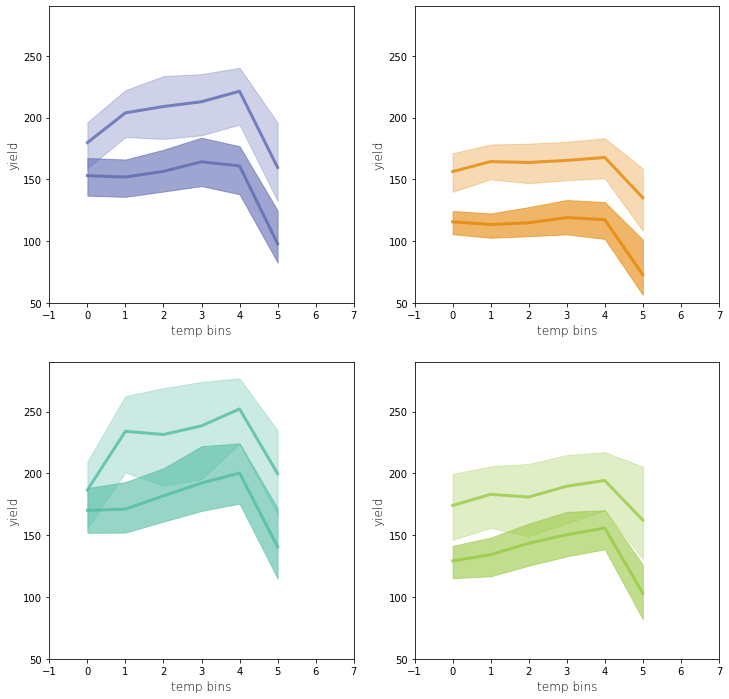

In [661]:
# set up colors
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
colors = [c1,c2,c3,c4]

# set up temp bins
n_bins = 6
phenogroups = [[4,65,46], [44,58,62], [88,9], [5]]

# visualization
fig = plt.figure(figsize=(12,12))

for pos, (phenos, c) in enumerate(zip(phenogroups, colors)):
    ax = fig.add_subplot(2,2,pos+1)
    ax.set_xlim(-1, n_bins+1)
    ax.set_ylim((50,290))
    ax.set_xlabel('temp bins', fontweight='light', fontsize=12)
    ax.set_ylabel('yield', fontweight='light', fontsize=12)
    df_s = df_all[df_all.cvar.isin(phenos)]
    bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
    df_sub = df_s.copy()
    df_sub.loc[:,'bins'] = bins
    upper_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 75),2) for item in np.arange(n_bins)]
    mid_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 50),2) for item in np.arange(n_bins)]
    lower_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 25),2) for item in np.arange(n_bins)]
    temp_means = df_sub.groupby('bins').mean().temp
    ax.plot(np.arange(n_bins), mid_yield, color=c, linewidth=3, alpha=0.8)
    ax.fill_between(np.arange(n_bins), upper_yield, lower_yield,
                    color=c, alpha=0.3)

    df_s = df_all_f2100[df_all_f2100.cvar.isin(phenos)]
    bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
    df_sub = df_s.copy()
    df_sub.loc[:,'bins'] = bins
    upper_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 75),2) for item in np.arange(n_bins)]
    mid_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 50),2) for item in np.arange(n_bins)]
    lower_yield = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 25),2) for item in np.arange(n_bins)]
    temp_means = df_sub.groupby('bins').mean().temp
    ax.plot(np.arange(n_bins), mid_yield, color=c, linewidth=3, alpha=0.8)
    ax.fill_between(np.arange(n_bins), upper_yield, lower_yield,
                    color=c, alpha=0.6)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatterbins_temp_yield.png', format='png', dpi=800)

In [215]:
# fetch data for strategy
sens = []
for item, phenos in enumerate(phenogroups):
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear','temp','vpd','precip']]

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear','temp','vpd','precip']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])
    df_s_mergedmean = df_s_merged.groupby('site').mean()
    
    # Normalize colors
    xs_present = df_s_mergedmean.temp_x.tolist()
    ys_present = df_s_mergedmean.dm_ear_x.tolist()
    xs_f2100 = df_s_mergedmean.temp_y.tolist()
    ys_f2100 = df_s_mergedmean.dm_ear_y.tolist()

    for item in np.arange(df_s_mergedmean.shape[0]):
        x1 = xs_present[item]
        x2 = xs_f2100[item]
        y1 = ys_present[item]
        y2 = ys_f2100[item]
#        sen = (y2-y1)/(x2-x1)*-1
        sen = (y2-y1)/(x2-x1)
        sens.append(sen)

sens = np.array(sens)
norm = plt.Normalize(sens.min(), sens.max())

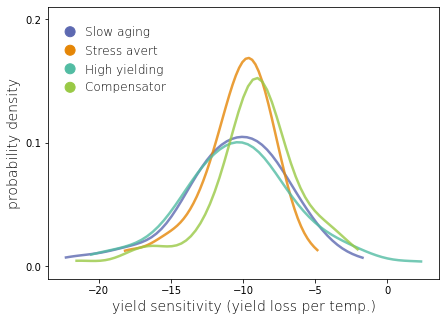

In [320]:
#https://stackoverflow.com/questions/15415455/plotting-probability-density-function-by-sample-with-matplotlib
# plot parameters
p1s = [0,60,120,180]
p2s = [60,120,180,240]
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
cols = [c1,c2,c3,c4]

# visualization
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()

for item in np.arange(4):
    data = sens[p1s[item]:p2s[item]]
    kde = gaussian_kde( data )
    dist_space = linspace(min(data), max(data), 60)
    ax.plot(dist_space, kde(dist_space), color=cols[item], alpha=0.8, linewidth=2.5)

ax.scatter([-22,-22,-22,-22], [0.19, 0.175, 0.16, 0.145],
           s=100, c=[c1,c2,c3,c4])
ax.annotate('Slow aging', (-21, 0.187), fontsize=12, fontweight='light')
ax.annotate('Stress avert', (-21, 0.171), fontsize=12, fontweight='light')
ax.annotate('High yielding', (-21, 0.156), fontsize=12, fontweight='light')
ax.annotate('Compensator', (-21, 0.142), fontsize=12, fontweight='light')

ax.set_ylim(-0.01, 0.21)
ax.set_yticks([0,0.1,0.2])
ax.set_xlabel('yield sensitivity (yield loss per temp.)', fontsize=14, fontweight='light')
ax.set_ylabel('probability density', fontsize=14, fontweight='light')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/pdf_yield_sensitivity.png', format='png', dpi=800)

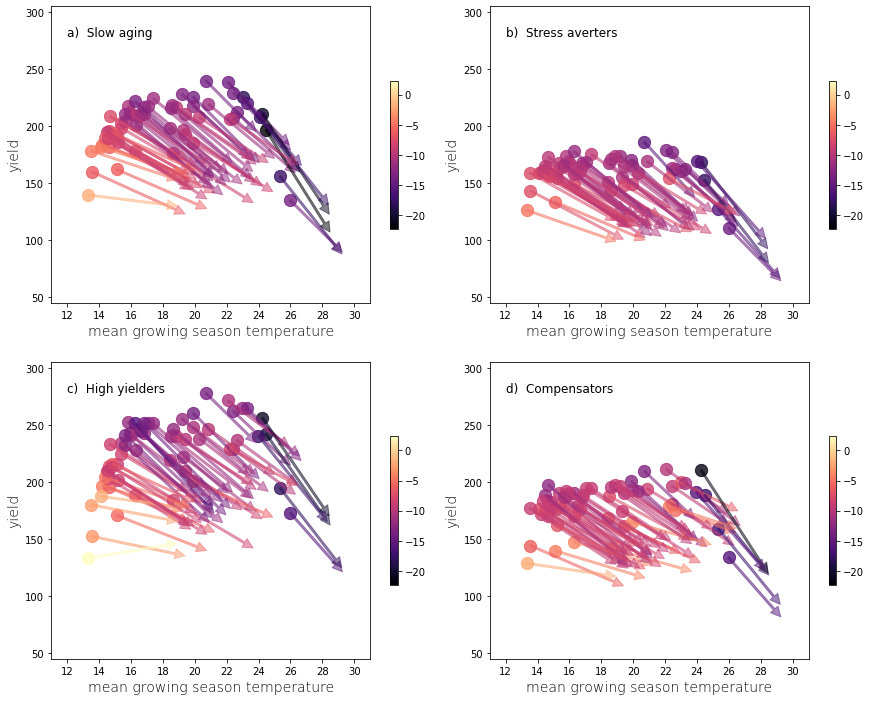

In [321]:
#PuOr = plt.get_cmap(PuOr_7.mpl_colormap)
#PuOr = plt.get_cmap(PuOr_7.mpl_colormap.reversed())
Magma = plt.get_cmap(Magma_10.mpl_colormap)

alphabets = ['a)  Slow aging', 'b)  Stress averters',
             'c)  High yielders', 'd)  Compensators']

fig = plt.figure(figsize=(15,12))
    
for pos, phenos in enumerate(phenogroups):
    ax = fig.add_subplot(2,2,pos+1)
    ax.set_xlim(11,31)
    ax.set_ylim(45,305)

    # visualize
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear','temp','vpd','precip']]

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear','temp','vpd','precip']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])
    df_s_mergedmean = df_s_merged.groupby('site').mean()
    
    # Normalize colors
    xs_present = df_s_mergedmean.temp_x.tolist()
    ys_present = df_s_mergedmean.dm_ear_x.tolist()
    xs_f2100 = df_s_mergedmean.temp_y.tolist()
    ys_f2100 = df_s_mergedmean.dm_ear_y.tolist()

    for item in np.arange(df_s_mergedmean.shape[0]):
        x1 = xs_present[item]
        x2 = xs_f2100[item]
        y1 = ys_present[item]
        y2 = ys_f2100[item]
        sen = (y2-y1)/(x2-x1)
        
        ax.scatter(x1, y1, color=Magma(norm(sen)), s=150, alpha=0.8)
        ax.scatter(x2, y2, s=0, color=Magma(norm(sen)))
        ax.annotate('', (x2, y2), 
                    xytext=(x1, y1), 
                    arrowprops=dict(color=Magma(norm(sen)),
                                    width=2, headwidth=10,
                                    headlength=10, alpha=0.5))


    sc_cmap = plt.scatter(1, 1, c=1, s=0,
                          cmap=Magma_10.mpl_colormap,
                          vmin=sens.min(), vmax=sens.max())
        
    plt.colorbar(sc_cmap, shrink=0.5)
    ax.set_xticks(np.arange(12,32,2))
    ax.set_xticklabels(np.arange(12,32,2))
    ax.set_xlabel('mean growing season temperature', 
                  fontweight='light', fontsize=14)
    ax.set_ylabel('yield', fontweight='light', fontsize=14)
    ax.annotate(f'{alphabets[pos]}', xy=(0.05, 0.9), 
                xycoords='axes fraction', fontsize=12)
    

fig.subplots_adjust(wspace=0.1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatterarrows_temp_yield_seqcmap.png', format='png', dpi=800)

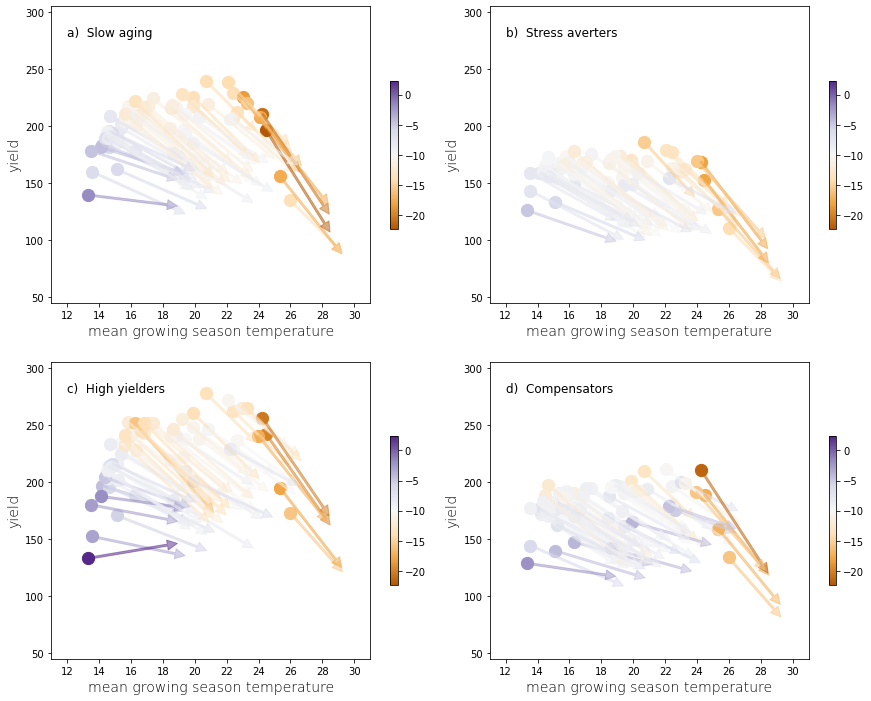

In [231]:
PuOr = plt.get_cmap(PuOr_7.mpl_colormap)
#PuOr = plt.get_cmap(PuOr_7.mpl_colormap.reversed())
#Magma = plt.get_cmap(Magma_10.mpl_colormap.reversed())

alphabets = ['a)  Slow aging', 'b)  Stress averters',
             'c)  High yielders', 'd)  Compensators']

fig = plt.figure(figsize=(15,12))
    
for pos, phenos in enumerate(phenogroups):
    ax = fig.add_subplot(2,2,pos+1)
    ax.set_xlim(11,31)
    ax.set_ylim(45,305)

    # visualize
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear','temp','vpd','precip']]

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear','temp','vpd','precip']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])
    df_s_mergedmean = df_s_merged.groupby('site').mean()
    
    # Normalize colors
    xs_present = df_s_mergedmean.temp_x.tolist()
    ys_present = df_s_mergedmean.dm_ear_x.tolist()
    xs_f2100 = df_s_mergedmean.temp_y.tolist()
    ys_f2100 = df_s_mergedmean.dm_ear_y.tolist()

    for item in np.arange(df_s_mergedmean.shape[0]):
        x1 = xs_present[item]
        x2 = xs_f2100[item]
        y1 = ys_present[item]
        y2 = ys_f2100[item]
        sen = (y2-y1)/(x2-x1)
        
        ax.scatter(x1, y1, color=PuOr(norm(sen)), s=150)
        ax.scatter(x2, y2, s=0, color=PuOr(norm(sen)))
        ax.annotate('', (x2, y2), 
                    xytext=(x1, y1), 
                    arrowprops=dict(color=PuOr(norm(sen)),
                                    width=2, headwidth=10,
                                    headlength=10, alpha=0.5))


    sc_cmap = plt.scatter(1, 1, c=1, s=0,
                          cmap=PuOr_7.mpl_colormap,
                          vmin=sens.min(), vmax=sens.max())
        
    plt.colorbar(sc_cmap, shrink=0.5)
    ax.set_xticks(np.arange(12,32,2))
    ax.set_xticklabels(np.arange(12,32,2))
    ax.set_xlabel('mean growing season temperature', 
                  fontweight='light', fontsize=14)
    ax.set_ylabel('yield', fontweight='light', fontsize=14)
    ax.annotate(f'{alphabets[pos]}', xy=(0.05, 0.9), 
                xycoords='axes fraction', fontsize=12)
    

fig.subplots_adjust(wspace=0.1)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatterarrows_temp_yield.png', format='png', dpi=800)

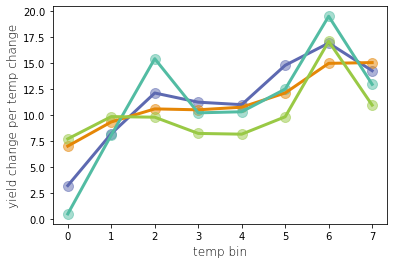

In [81]:
# set up colors
c1 = Vivid_4.mpl_colors[1]
c2 = Vivid_4.mpl_colors[0]
c3 = Vivid_4.mpl_colors[2]
c4 = Vivid_4.mpl_colors[3]
colors = [c1,c2,c3,c4]

# set up temp bins
n_bins = 8

phenogroups = [[4,65,46], [44,58,62], [88,9], [5]]

# visualization
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

for pos, (phenos, c) in enumerate(zip(phenogroups, colors)):
    ax.set_xlabel('temp bin', fontweight='light', fontsize=12)
    ax.set_ylabel('yield change per temp change', fontweight='light', fontsize=12)
    df_s = df_all[df_all.cvar.isin(phenos)]
    bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
    df_sub = df_s.copy()
    df_sub.loc[:,'bins'] = bins
    upper_yield_present = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 75),2) for item in np.arange(n_bins)]
    mid_yield_present = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 50),2) for item in np.arange(n_bins)]
    lower_yield_present = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 25),2) for item in np.arange(n_bins)]
    temp_means_present = df_sub.groupby('bins').mean().temp

    df_s = df_all_f2100[df_all_f2100.cvar.isin(phenos)]
    bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
    df_sub = df_s.copy()
    df_sub.loc[:,'bins'] = bins
    upper_yield_f2100 = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 75),2) for item in np.arange(n_bins)]
    mid_yield_f2100 = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 50),2) for item in np.arange(n_bins)]
    lower_yield_f2100 = [round(np.percentile(df_sub.query(f'bins=={item}').dm_ear, 25),2) for item in np.arange(n_bins)]
    temp_means_f2100 = df_sub.groupby('bins').mean().temp

    temp_diff = [temp_means_f2100[item] - temp_means_present[item] for item in np.arange(n_bins)]
    mid_yield_diff = [mid_yield_present[item] - mid_yield_f2100[item] for item in np.arange(n_bins)]
    upper_yield_diff = [upper_yield_present[item] - upper_yield_f2100[item] for item in np.arange(n_bins)]
    lower_yield_diff = [lower_yield_present[item] - lower_yield_f2100[item] for item in np.arange(n_bins)]
    dy_dt = [mid_yield_diff[item] / temp_diff[item] for item in np.arange(n_bins)]

    ax.scatter(np.arange(n_bins), dy_dt, color=c, s=100, alpha=0.5)
    ax.plot(np.arange(n_bins), dy_dt, color=c, linewidth=3)
#    ax.scatter(np.arange(n_bins), mid_yield_diff, color=c, s=100, alpha=0.8, marker='^')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatterbins_temp_yield.png', format='png', dpi=800)

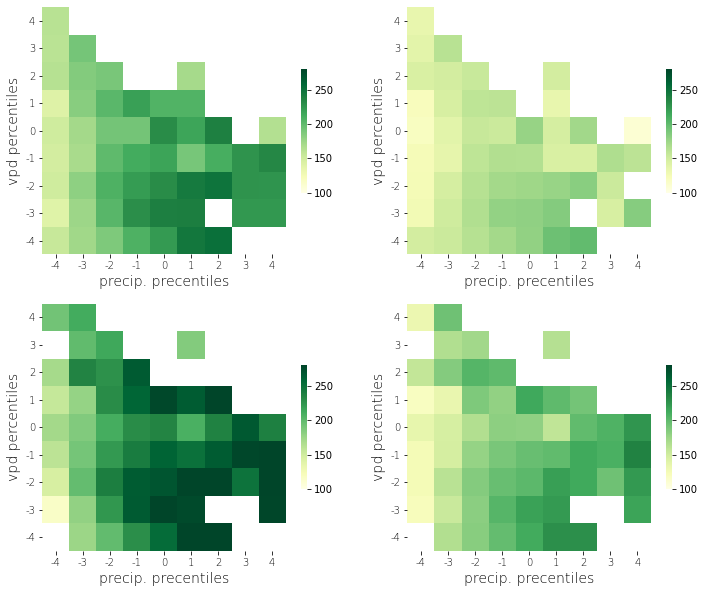

In [236]:
n_bins_vpd = 9
n_bins_precip = 9

fig = plt.figure(figsize=(12,10))

for item, phenos in enumerate(phenogroups):
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)

    bins_vpd = pd.cut(df_s.vpd, n_bins_vpd, labels=np.arange(n_bins_vpd).tolist())
    bins_precip = pd.cut(df_s.precip, n_bins_precip, labels=np.arange(n_bins_precip).tolist())
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear']]
    df_s_present['bins_vpd'] = bins_vpd
    df_s_present['bins_precip'] = bins_precip

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])

    
    mx = np.zeros((n_bins_vpd, n_bins_precip))
    for bin_vpd in np.arange(n_bins_vpd):
        for bin_precip in np.arange(n_bins_precip):
            mx[(n_bins_vpd-bin_vpd-1), bin_precip] = df_s_merged.query(
                f'bins_vpd=={bin_vpd}').query(
                f'bins_precip=={bin_precip}').dm_ear_x.mean()

    ax = fig.add_subplot(2,2,item+1)    
    hm = sns.heatmap(mx, cmap=YlGn_9.mpl_colormap,
                     vmin=100, vmax=280,
                     cbar_kws={'shrink': 0.5})

    ax.set_xlabel('precip. precentiles', fontweight='light', fontsize=14)
    ax.set_xticks(np.arange(0.5,9.5))
    ax.set_xticklabels(np.arange(-4,5), fontweight='light')
    ax.set_ylabel('vpd percentiles', fontweight='light', fontsize=14)
    ax.set_yticks(np.arange(0.5,9.5)[::-1])
    ax.set_yticklabels(np.arange(-4,5), fontweight='light', rotation=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_cspace_yield_precip_vpd.png', format='png', dpi=800)

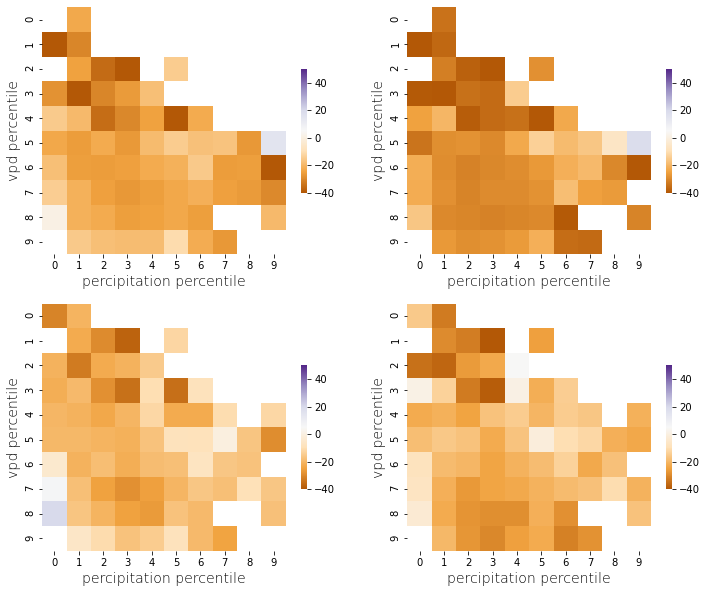

In [82]:
fig = plt.figure(figsize=(12,10))

for item, phenos in enumerate(phenogroups):
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)

    n_bins_vpd = 10
    n_bins_precip = 10

    bins_vpd = pd.cut(df_s.vpd, n_bins_vpd, labels=np.arange(n_bins_vpd).tolist())
    bins_precip = pd.cut(df_s.precip, n_bins_precip, labels=np.arange(n_bins_precip).tolist())
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear']]
    df_s_present['bins_vpd'] = bins_vpd
    df_s_present['bins_precip'] = bins_precip

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])

    
    mx = np.zeros((n_bins_vpd, n_bins_precip))
    for bin_vpd in np.arange(n_bins_vpd):
        for bin_precip in np.arange(n_bins_precip):
            dm_ear_present = df_s_merged.query(
                f'bins_precip=={bin_precip}').query(
                f'bins_vpd=={bin_vpd}').dm_ear_x.mean()
            dm_ear_f2100 = df_s_merged.query(
                f'bins_precip=={bin_precip}').query(
                f'bins_vpd=={bin_vpd}').dm_ear_y.mean()
            mx[(n_bins_vpd-bin_vpd-1), bin_precip] = ((dm_ear_f2100 - dm_ear_present)/dm_ear_present)*100

    ax = fig.add_subplot(2,2,item+1)    
    hm = sns.heatmap(mx, cmap=PuOr_7.mpl_colormap,
                     vmin=-40, vmax=50, cbar_kws={'shrink':0.5})

    ax.set_xlabel('percipitation percentile', fontweight='light', fontsize=14)
    ax.set_ylabel('vpd percentile', fontweight='light', fontsize=14)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_cspace_yieldloss_precip_vpd.png', format='png', dpi=800)

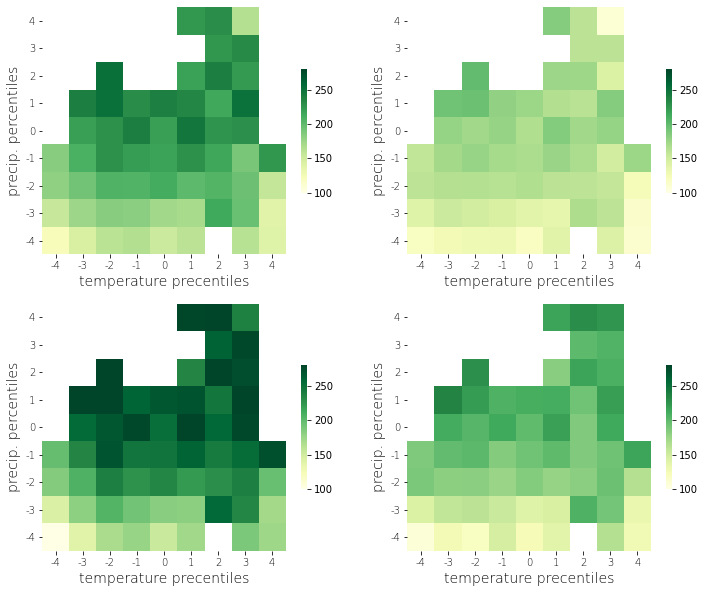

In [234]:
fig = plt.figure(figsize=(12,10))

for item, phenos in enumerate(phenogroups):
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)

    n_bins_temp = 9
    n_bins_precip = 9

    bins_temp = pd.cut(df_s.temp, n_bins_temp, labels=np.arange(n_bins_temp).tolist())
    bins_precip = pd.cut(df_s.precip, n_bins_precip, labels=np.arange(n_bins_precip).tolist())
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear']]
    df_s_present['bins_temp'] = bins_temp
    df_s_present['bins_precip'] = bins_precip

    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])

    mx = np.zeros((n_bins_precip, n_bins_temp))
    for bin_precip in np.arange(n_bins_precip):
        for bin_temp in np.arange(n_bins_temp):
            mx[(n_bins_precip-bin_precip-1), bin_temp] = df_s_merged.query(
                f'bins_temp=={bin_temp}').query(
                f'bins_precip=={bin_precip}').dm_ear_x.mean()

    ax = fig.add_subplot(2,2,item+1)    
    hm = sns.heatmap(mx, cmap=YlGn_9.mpl_colormap,
                     vmin=100, vmax=280,
                     cbar_kws={'shrink': 0.5})
    
    ax.set_xlabel('temperature precentiles', fontweight='light', fontsize=14)
    ax.set_xticks(np.arange(0.5,9.5))
    ax.set_xticklabels(np.arange(-4,5), fontweight='light')
    ax.set_ylabel('precip. percentiles', fontweight='light', fontsize=14)
    ax.set_yticks(np.arange(0.5,9.5)[::-1])
    ax.set_yticklabels(np.arange(-4,5), fontweight='light', rotation=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_cspace_yield_temp_precip.png', format='png', dpi=800)

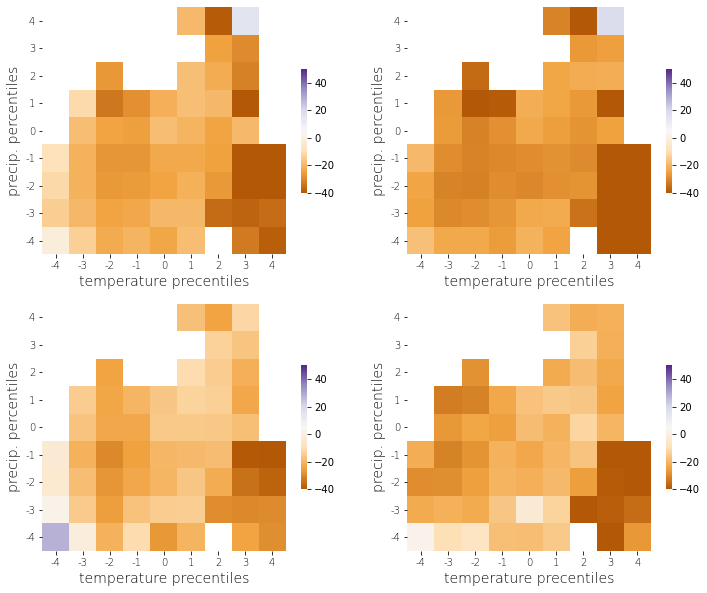

In [108]:
phenogroups = [[4,65,46], [44,58,62], [88,9], [5]]
n_bins_temp = 9
n_bins_precip = 9

fig = plt.figure(figsize=(12,10))

for item, phenos in enumerate(phenogroups):
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)
    bins_temp = pd.cut(df_s.temp, n_bins_temp, labels=np.arange(n_bins_temp).tolist())
    bins_precip = pd.cut(df_s.precip, n_bins_precip, labels=np.arange(n_bins_precip).tolist())
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear']]
    df_s_present['bins_temp'] = bins_temp
    df_s_present['bins_precip'] = bins_precip
    
    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])

    mx = np.zeros((n_bins_precip, n_bins_temp))
    for bin_precip in np.arange(n_bins_precip):
        for bin_temp in np.arange(n_bins_temp):
            dm_ear_present = df_s_merged.query(
                f'bins_temp=={bin_temp}').query(
                f'bins_precip=={bin_precip}').dm_ear_x.mean()
            dm_ear_f2100 = df_s_merged.query(
                f'bins_temp=={bin_temp}').query(
                f'bins_precip=={bin_precip}').dm_ear_y.mean()
            mx[(n_bins_precip-bin_precip-1), bin_temp] = ((dm_ear_f2100 - dm_ear_present)/dm_ear_present)*100

    ax = fig.add_subplot(2,2,item+1)    
    hm = sns.heatmap(mx, cmap=PuOr_7.mpl_colormap,
                     vmin=-40, vmax=50, cbar_kws={'shrink':0.5})

    ax.set_xlabel('temperature precentiles', fontweight='light', fontsize=14)
    ax.set_xticks(np.arange(0.5,9.5))
    ax.set_xticklabels(np.arange(-4,5), fontweight='light')
    ax.set_ylabel('precip. percentiles', fontweight='light', fontsize=14)
    ax.set_yticks(np.arange(0.5,9.5)[::-1])
    ax.set_yticklabels(np.arange(-4,5), fontweight='light', rotation=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_cspace_yieldloss_temp_precip.png', format='png', dpi=800)

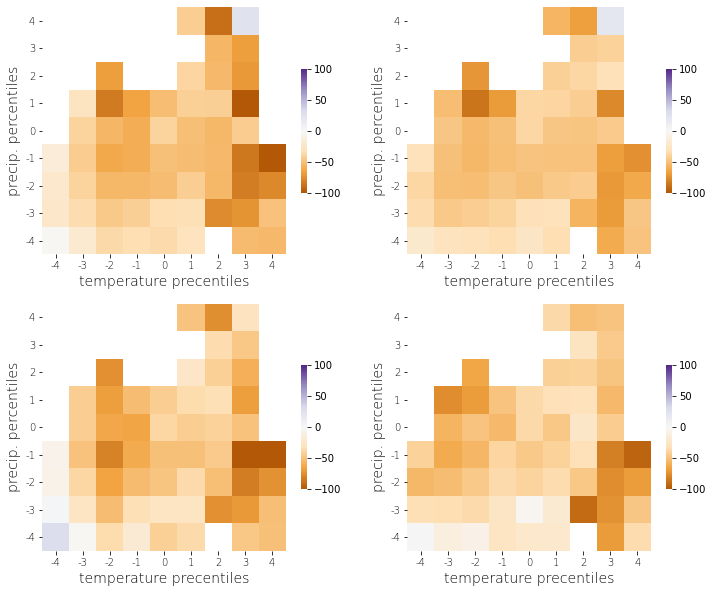

In [185]:
phenogroups = [[4,65,46], [44,58,62], [88,9], [5]]
n_bins_temp = 9
n_bins_precip = 9

fig = plt.figure(figsize=(12,10))

for item, phenos in enumerate(phenogroups):
    df_s = df_all[df_all.cvar.isin(phenos)].reset_index(drop=True)
    bins_temp = pd.cut(df_s.temp, n_bins_temp, labels=np.arange(n_bins_temp).tolist())
    bins_precip = pd.cut(df_s.precip, n_bins_precip, labels=np.arange(n_bins_precip).tolist())
    df_s_present = df_s.copy()[['year','cvar','site','dm_ear']]
    df_s_present['bins_temp'] = bins_temp
    df_s_present['bins_precip'] = bins_precip
    
    df_s_f2100 = df_all_f2100[df_all_f2100.cvar.isin(phenos)].reset_index(drop=True)[['year','cvar','site','dm_ear']]
    df_s_f2100.site = df_s_f2100.site.astype(int)
    df_s_merged = df_s_present.merge(df_s_f2100, how='left', on=['year','cvar','site'])

    mx = np.zeros((n_bins_precip, n_bins_temp))
    for bin_precip in np.arange(n_bins_precip):
        for bin_temp in np.arange(n_bins_temp):
            dm_ear_present = df_s_merged.query(
                f'bins_temp=={bin_temp}').query(
                f'bins_precip=={bin_precip}').dm_ear_x.mean()
            dm_ear_f2100 = df_s_merged.query(
                f'bins_temp=={bin_temp}').query(
                f'bins_precip=={bin_precip}').dm_ear_y.mean()
            mx[(n_bins_precip-bin_precip-1), bin_temp] = dm_ear_f2100 - dm_ear_present

    ax = fig.add_subplot(2,2,item+1)    
    hm = sns.heatmap(mx, cmap=PuOr_7.mpl_colormap,
                     vmin=-100, vmax=100, 
                     cbar_kws={'shrink':0.5})

    ax.set_xlabel('temperature precentiles', fontweight='light', fontsize=14)
    ax.set_xticks(np.arange(0.5,9.5))
    ax.set_xticklabels(np.arange(-4,5), fontweight='light')
    ax.set_ylabel('precip. percentiles', fontweight='light', fontsize=14)
    ax.set_yticks(np.arange(0.5,9.5)[::-1])
    ax.set_yticklabels(np.arange(-4,5), fontweight='light', rotation=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_cspace_yieldloss_temp_precip.png', format='png', dpi=800)

## Trying to figure out what's up with precip
- Why do we see this clear relationship between precip & yield, but don't really see a clear relationship in most of the processes?
- I know that water stress (identiifed through leaf water potential) more directly links with gs. However, I can't pick up how that signal propagates downstream.
- I thought maybe water stress imapcts thorugh gs was minimal, and the larger impact likely came from impacts on leaf expansion, and thus total leaf area. However, I'm having a hard time picking up a clear enough relationship.
- So now this really puzzels me. Why am I seeing this pretty strong relationship between precip and final yield, but can't seem to figure out what is actually causing this difference!?

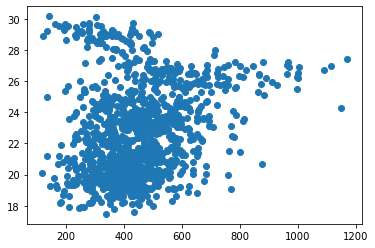

In [117]:
plt.scatter(df_sub.precip, df_sub.temp)

Text(0, 0.5, 'yield')

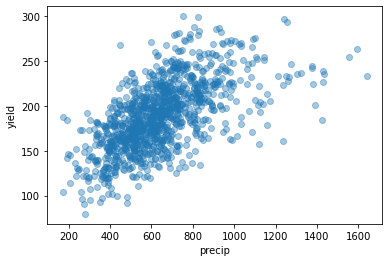

In [80]:
pheno=81
df_sub = df_all.query(f'cvar=={pheno}')
plt.scatter(df_sub.precip, df_sub.dm_ear, alpha=0.4)
df_sub = df_all_f2100.query(f'cvar=={pheno}')
#plt.scatter(df_sub.precip, df_sub.dm_ear, alpha=0.2)
plt.xlabel('precip')
plt.ylabel('yield')

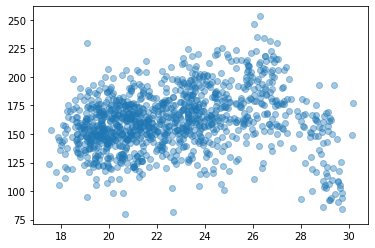

In [119]:
plt.scatter(df_sub.temp, df_sub.dm_ear, alpha=0.4)

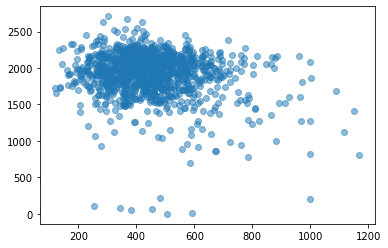

In [106]:
pheno = 44
df_leaves_sub = df_leaves.query(f'cvar=={pheno}').groupby(['site','year']).max().LA.reset_index()
df_wea.site = df_wea.site.astype(int)
df_leaves_sub_merged = df_leaves_sub.merge(df_wea, on=['site','year'])
plt.scatter(df_leaves_sub_merged.precip, df_leaves_sub_merged.LA, alpha=0.5)

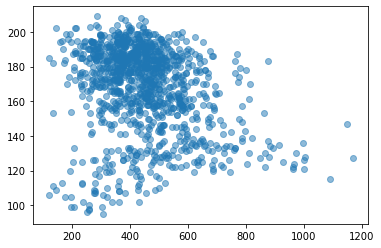

In [114]:
pheno = 44

df_pheno_sub = df_phenology[df_phenology.pheno=='"grainFill"'].query(f'cvar=={pheno}')
df_wea.site = df_wea.site.astype(int)
df_pheno_sub_merged = df_pheno_sub.merge(df_wea, on=['site','year'])
df_pheno_sub_merged.head()

plt.scatter(df_pheno_sub_merged.precip, df_pheno_sub_merged.jday, alpha=0.5)
# this nonsense pattern is probably just confounded with temp

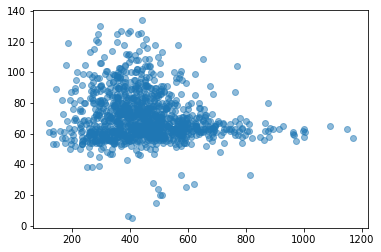

In [115]:
plt.scatter(df_pheno_sub_merged.precip, df_pheno_sub_merged.pheno_days, alpha=0.5)
# this nonsense pattern is probably just confounded with temp

Text(0, 0.5, 'yield')

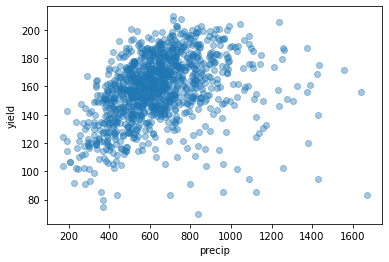

In [75]:
pheno=44
df_sub = df_all.query(f'cvar=={pheno}')
plt.scatter(df_sub.precip, df_sub.dm_ear, alpha=0.4)
df_sub = df_all_f2100.query(f'cvar=={pheno}')
#plt.scatter(df_sub.precip, df_sub.dm_ear, alpha=0.2)
plt.xlabel('precip')
plt.ylabel('yield')

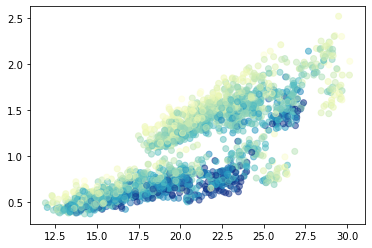

In [281]:
df_s = df_all.query(f'cvar=={phenos[8]}')
bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
df_sub = df_s.copy()
plt.scatter(df_sub.temp, df_sub.vpd, 
            c=df_sub.precip, cmap=YlGnBu_8.mpl_colormap, alpha=0.5,
            vmax=1000)

df_s = df_all_f2100.query(f'cvar=={phenos[8]}')
bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
df_sub = df_s.copy()
plt.scatter(df_sub.temp, df_sub.vpd, 
            c=df_sub.precip, cmap=YlGnBu_8.mpl_colormap, alpha=0.5,
            vmax=1000)


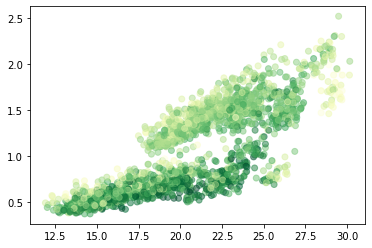

In [284]:
df_s = df_all.query(f'cvar=={phenos[8]}')
bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
df_sub = df_s.copy()
plt.scatter(df_sub.temp, df_sub.vpd, 
            c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.5, vmax=250)

df_s = df_all_f2100.query(f'cvar=={phenos[8]}')
bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
df_sub = df_s.copy()
plt.scatter(df_sub.temp, df_sub.vpd, 
            c=df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.5, vmax=250)


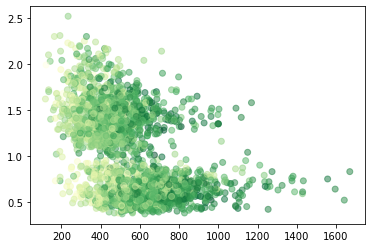

In [265]:
df_s = df_all.query(f'cvar=={phenos[8]}')
bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
df_sub = df_s.copy()
plt.scatter(df_sub.precip, df_sub.vpd, 
            c = df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.5)

df_s = df_all_f2100.query(f'cvar=={phenos[8]}')
bins = pd.cut(df_s.temp, n_bins, labels=np.arange(n_bins).tolist())
df_sub = df_s.copy()
plt.scatter(df_sub.precip, df_sub.vpd, 
            c = df_sub.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.5)


In [243]:
def density_estimation(m1, m2):
    xmin = min(m1)
    xmax = max(m1)
    ymin = min(m2)
    ymax = max(m2)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

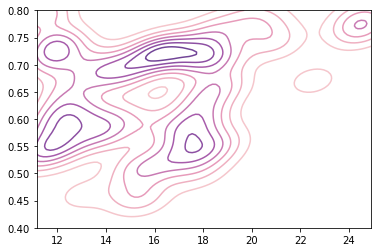

In [249]:
# rank phenos
phenos_ranked = rank_top_phenos('present', 100, 1, 1)

# put together params info
df_params_s = df_params.iloc[:,:-1][:100]
df_params_sub = df_params_s.iloc[phenos_ranked]

xs = df_params_sub['juv_leaves']
ys = df_params_sub['rmax_ltar']

xs_list = []
for item, x in enumerate(xs):
    if item < 50:
        xs_amplified = [[x]*(100-item)]
    else:
        xs_amplified = [[x]*(1)]
    
    xs_list.append(xs_amplified)

ys_list = []
for item, y in enumerate(ys):
    if item < 50:
        ys_amplified = [[y]*(100-item)]
    else:
        ys_amplified = [[y]*(1)]
    
    ys_list.append(ys_amplified)

    
xs_flat = list(itertools.chain(*xs_list))
ys_flat = list(itertools.chain(*ys_list))
xs_flat2 = list(itertools.chain(*xs_flat))
ys_flat2 = list(itertools.chain(*ys_flat))

X, Y, Z = density_estimation(xs_flat2, ys_flat2)
plt.contour(X, Y, Z, 
            cmap=PurpOr_6.mpl_colormap)


## Performance in cspace

All site-years in climate space:

Text(0, 0.5, 'precip')

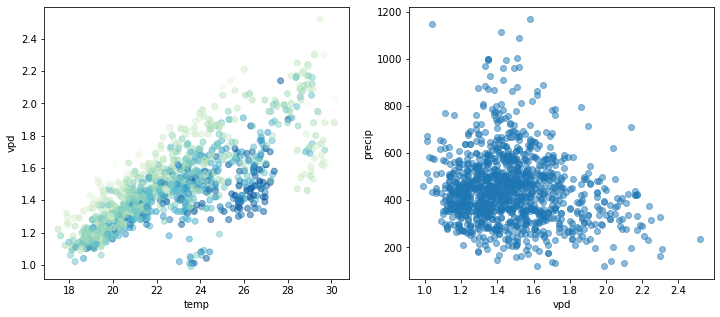

In [243]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_wea.temp, df_wea.vpd, c=df_wea.precip, 
            cmap=GnBu_8.mpl_colormap, alpha=0.5, vmax=700)
ax1.set_xlabel('temp')
ax1.set_ylabel('vpd')

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_wea.vpd, df_wea.precip, alpha=0.5)
ax2.set_xlabel('vpd')
ax2.set_ylabel('precip')

### Cluster based on site-year climate info
- Treating each site-year as individual samples
- One down side with treating each site-year as individuals is that it's hard to relate to the clustered groups. Can't project back onto a map.
- Can think about tweaking what features to use to cluster sites, but I don't think it'll make a big difference.
- Q: should I pre-process before clustering?

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df_climate = df_wea[['temp', 'vpd', 'precip']]
df_climate_std = StandardScaler().fit_transform(df_climate)

kmeans_mod = KMeans(n_clusters=4)
kmeans_mod.fit(df_climate_std)
y_kmeans = kmeans_mod.predict(df_climate_std)

df_cluster = df_wea.copy()
df_cluster['group'] = y_kmeans

df_km0 = df_cluster.query('group==0')
df_km1 = df_cluster.query('group==1')
df_km2 = df_cluster.query('group==2')
df_km3 = df_cluster.query('group==3')
df_km4 = df_cluster.query('group==4')

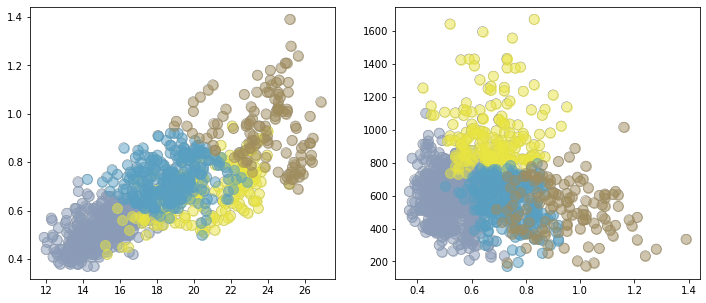

In [5]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_wea.temp, df_wea.vpd, facecolor='none', edgecolor='grey', linewidth=0.5, s=100)
ax1.scatter(df_km0.temp, df_km0.vpd, color=Aquatic2_5.mpl_colors[0], s=100, alpha=0.5)
ax1.scatter(df_km1.temp, df_km1.vpd, color=Aquatic2_5.mpl_colors[1], s=100, alpha=0.5)
ax1.scatter(df_km2.temp, df_km2.vpd, color=Aquatic2_5.mpl_colors[2], s=100, alpha=0.5)
ax1.scatter(df_km3.temp, df_km3.vpd, color=Aquatic2_5.mpl_colors[3], s=100, alpha=0.5)
ax1.scatter(df_km4.temp, df_km4.vpd, color=Aquatic2_5.mpl_colors[4], s=100, alpha=0.5)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_wea.vpd, df_wea.precip, facecolor='none', edgecolor='grey', linewidth=0.5, s=100)
ax2.scatter(df_km0.vpd, df_km0.precip, color=Aquatic2_5.mpl_colors[0], s=100, alpha=0.5)
ax2.scatter(df_km1.vpd, df_km1.precip, color=Aquatic2_5.mpl_colors[1], s=100, alpha=0.5)
ax2.scatter(df_km2.vpd, df_km2.precip, color=Aquatic2_5.mpl_colors[2], s=100, alpha=0.5)
ax2.scatter(df_km3.vpd, df_km3.precip, color=Aquatic2_5.mpl_colors[3], s=100, alpha=0.5)
ax2.scatter(df_km4.vpd, df_km4.precip, color=Aquatic2_5.mpl_colors[4], s=100, alpha=0.5)


### Cluster based on sites

Phenotype performance within clustered sites:

In [137]:
df_climate = df_all.groupby('site').mean()[['temp', 'vpd', 'precip']]
df_climate_std = StandardScaler().fit_transform(df_climate)

kmeans_mod = KMeans(n_clusters=4)
kmeans_mod.fit(df_climate_std)
y_kmeans = kmeans_mod.predict(df_climate_std)

df_cluster = df_climate.copy()
df_cluster['group'] = y_kmeans

df_km0 = df_cluster.query('group==0')
df_km1 = df_cluster.query('group==1')
df_km2 = df_cluster.query('group==2')
df_km3 = df_cluster.query('group==3')

df_sites.site = df_sites.site.astype(int)
df_clustered_sites = pd.merge(df_cluster, df_sites, left_on='site', right_on='site')

In [138]:
df_km0_sites = pd.merge(df_km0, df_sites, on='site')
df_km1_sites = pd.merge(df_km1, df_sites, on='site')
df_km2_sites = pd.merge(df_km2, df_sites, on='site')
df_km3_sites = pd.merge(df_km3, df_sites, on='site')

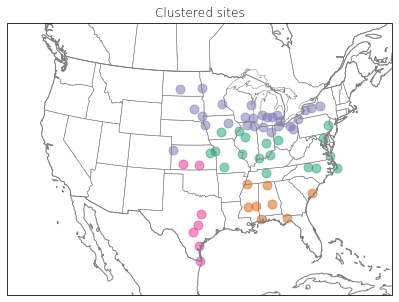

In [155]:
fig = plt.figure(figsize=(8,5))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))
mp = ax.scatter(df_km0_sites.lon, df_km0_sites.lat, 
                color=Dark2_4.mpl_colors[2], 
                s=80, alpha=0.5, transform=ccrs.PlateCarree())
mp = ax.scatter(df_km1_sites.lon, df_km1_sites.lat, 
                color=Dark2_4.mpl_colors[1], 
                s=80, alpha=0.5, transform=ccrs.PlateCarree())
mp = ax.scatter(df_km2_sites.lon, df_km2_sites.lat, 
                color=Dark2_4.mpl_colors[3], 
                s=80, alpha=0.5, transform=ccrs.PlateCarree())
mp = ax.scatter(df_km3_sites.lon, df_km3_sites.lat, 
                color=Dark2_4.mpl_colors[0], 
                s=80, alpha=0.5, transform=ccrs.PlateCarree())

ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('Clustered sites', fontweight='light', size=12)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/map_clustered_sites.png', format='png', dpi=800)

In [156]:
# fetch clustered sites indexes
km0_sites = df_clustered_sites[df_clustered_sites.site.isin(df_km0_sites.site)].index.tolist()
km1_sites = df_clustered_sites[df_clustered_sites.site.isin(df_km1_sites.site)].index.tolist()
km2_sites = df_clustered_sites[df_clustered_sites.site.isin(df_km2_sites.site)].index.tolist()
km3_sites = df_clustered_sites[df_clustered_sites.site.isin(df_km3_sites.site)].index.tolist()

In [164]:
df_pheno, mx_present = identify_top_phenos('present', 20, 1, 1)
df_pheno, mx_f2100 = identify_top_phenos('f2100', 20, 1, 1)

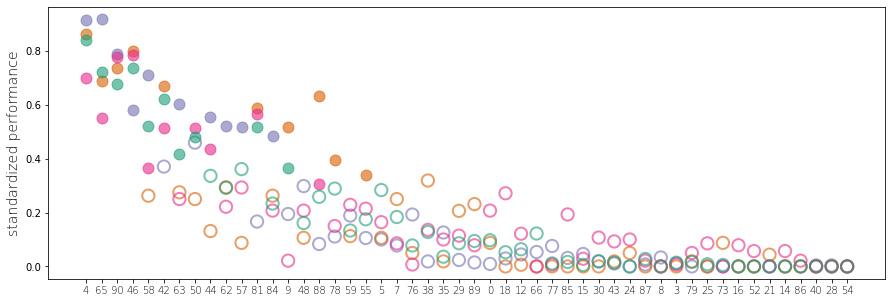

In [175]:
# visualization
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)

top_phenos = rank_top_phenos('present',20,1,1)

scores = []
sites = [km0_sites, km1_sites, km2_sites, km3_sites]
colors = [Dark2_4.mpl_colors[2], Dark2_4.mpl_colors[1],
          Dark2_4.mpl_colors[3], Dark2_4.mpl_colors[0]]

for site, color in zip(sites, colors):    
    scores = []
    for item in np.arange(len(top_phenos)):
        score = np.nansum(20-mx_present[np.ix_(top_phenos, site)][item])/(20*len(site))
        scores.append(score)

    df_scores = pd.DataFrame({'score': scores}).sort_values(by='score', ascending=False)
    scores_solid = df_scores[:10]['score']
    xs_solid = scores_solid.index
    scores_hollow = df_scores[10:]['score']
    xs_hollow = scores_hollow.index    
        
    ax.scatter(xs_solid, scores_solid,
               s=120, color=color, alpha=0.6)
    ax.scatter(xs_hollow, scores_hollow,
               s=150, facecolor='none', edgecolor=color, 
               linewidth=2, alpha=0.6)

ax.set_xticks(np.arange(50))
ax.set_xticklabels(top_phenos, fontweight='light')
ax.set_ylabel('standardized performance', fontweight='light', fontsize=14)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_stdrank_cspace_present.png', format='png', dpi=800)

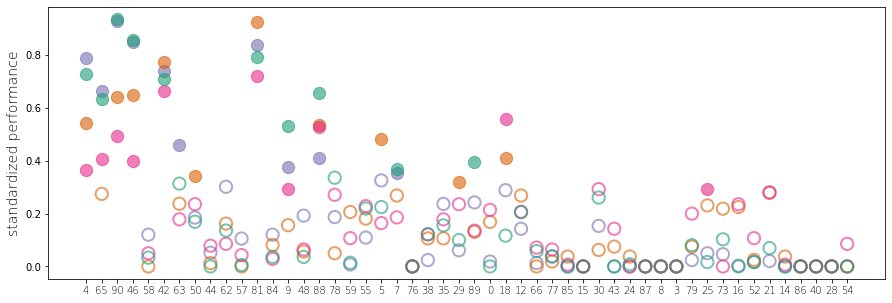

In [176]:
# visualization
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)

top_phenos = rank_top_phenos('present',20,1,1)

scores = []
sites = [km0_sites, km1_sites, km2_sites, km3_sites]
colors = [Dark2_4.mpl_colors[2], Dark2_4.mpl_colors[1],
          Dark2_4.mpl_colors[3], Dark2_4.mpl_colors[0]]

for site, color in zip(sites, colors):    
    scores = []
    for item in np.arange(len(top_phenos)):
        score = np.nansum(20-mx_f2100[np.ix_(top_phenos, site)][item])/(20*len(site))
        scores.append(score)

    df_scores = pd.DataFrame({'score': scores}).sort_values(by='score', ascending=False)
    scores_solid = df_scores[:10]['score']
    xs_solid = scores_solid.index
    scores_hollow = df_scores[10:]['score']
    xs_hollow = scores_hollow.index    
        
    ax.scatter(xs_solid, scores_solid,
               s=150, color=color, alpha=0.6)
    ax.scatter(xs_hollow, scores_hollow,
               s=150, facecolor='none', edgecolor=color, 
               linewidth=2, alpha=0.6)

ax.set_xticks(np.arange(50))
ax.set_xticklabels(top_phenos, fontweight='light')
ax.set_ylabel('standardized performance', fontweight='light', fontsize=14)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_stdrank_cspace_f2100.png', format='png', dpi=800)

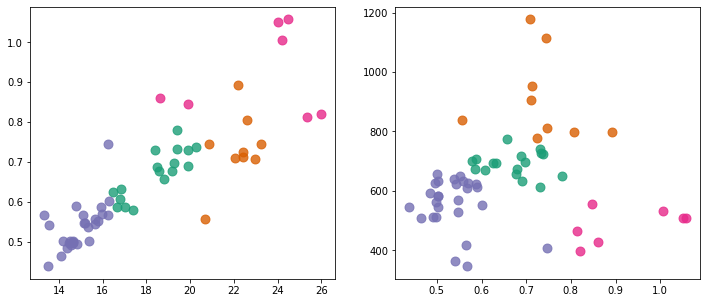

In [613]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_climate[df_climate.site.isin(df_km0.index)].temp, 
            df_climate[df_climate.site.isin(df_km0.index)].vpd, 
            color=Dark2_4.mpl_colors[0], s=80, alpha=0.8)
ax1.scatter(df_climate[df_climate.site.isin(df_km1.index)].temp, 
            df_climate[df_climate.site.isin(df_km1.index)].vpd, 
            color=Dark2_4.mpl_colors[3], s=80, alpha=0.8)
ax1.scatter(df_climate[df_climate.site.isin(df_km2.index)].temp, 
            df_climate[df_climate.site.isin(df_km2.index)].vpd, 
            color=Dark2_4.mpl_colors[1], s=80, alpha=0.8)
ax1.scatter(df_climate[df_climate.site.isin(df_km3.index)].temp, 
            df_climate[df_climate.site.isin(df_km3.index)].vpd, 
            color=Dark2_4.mpl_colors[2], s=80, alpha=0.8)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_climate[df_climate.site.isin(df_km0.index)].vpd, 
            df_climate[df_climate.site.isin(df_km0.index)].precip, 
            color=Dark2_4.mpl_colors[0], s=80, alpha=0.8)
ax2.scatter(df_climate[df_climate.site.isin(df_km1.index)].vpd, 
            df_climate[df_climate.site.isin(df_km1.index)].precip, 
            color=Dark2_4.mpl_colors[3], s=80, alpha=0.8)
ax2.scatter(df_climate[df_climate.site.isin(df_km2.index)].vpd, 
            df_climate[df_climate.site.isin(df_km2.index)].precip, 
            color=Dark2_4.mpl_colors[1], s=80, alpha=0.8)
ax2.scatter(df_climate[df_climate.site.isin(df_km3.index)].vpd, 
            df_climate[df_climate.site.isin(df_km3.index)].precip, 
            color=Dark2_4.mpl_colors[2], s=80, alpha=0.8)

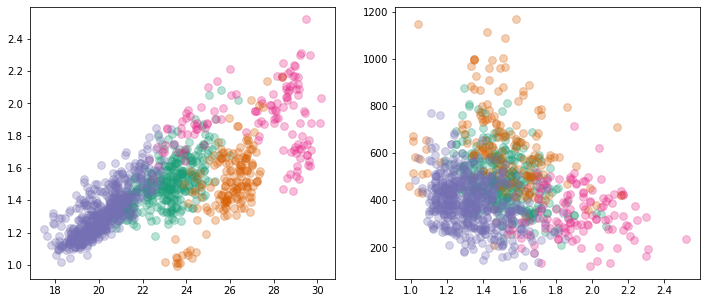

In [612]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_wea[df_wea.site.isin(df_km0.index)].temp, 
            df_wea[df_wea.site.isin(df_km0.index)].vpd, 
            color=Dark2_4.mpl_colors[0], s=60, alpha=0.3)
ax1.scatter(df_wea[df_wea.site.isin(df_km1.index)].temp, 
            df_wea[df_wea.site.isin(df_km1.index)].vpd, 
            color=Dark2_4.mpl_colors[3], s=60, alpha=0.3)
ax1.scatter(df_wea[df_wea.site.isin(df_km2.index)].temp, 
            df_wea[df_wea.site.isin(df_km2.index)].vpd, 
            color=Dark2_4.mpl_colors[1], s=60, alpha=0.3)
ax1.scatter(df_wea[df_wea.site.isin(df_km3.index)].temp, 
            df_wea[df_wea.site.isin(df_km3.index)].vpd, 
            color=Dark2_4.mpl_colors[2], s=60, alpha=0.3)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_wea[df_wea.site.isin(df_km0.index)].vpd, 
            df_wea[df_wea.site.isin(df_km0.index)].precip, 
            color=Dark2_4.mpl_colors[0], s=60, alpha=0.3)
ax2.scatter(df_wea[df_wea.site.isin(df_km1.index)].vpd, 
            df_wea[df_wea.site.isin(df_km1.index)].precip, 
            color=Dark2_4.mpl_colors[3], s=60, alpha=0.3)
ax2.scatter(df_wea[df_wea.site.isin(df_km2.index)].vpd, 
            df_wea[df_wea.site.isin(df_km2.index)].precip, 
            color=Dark2_4.mpl_colors[1], s=60, alpha=0.3)
ax2.scatter(df_wea[df_wea.site.isin(df_km3.index)].vpd, 
            df_wea[df_wea.site.isin(df_km3.index)].precip, 
            color=Dark2_4.mpl_colors[2], s=60, alpha=0.3)

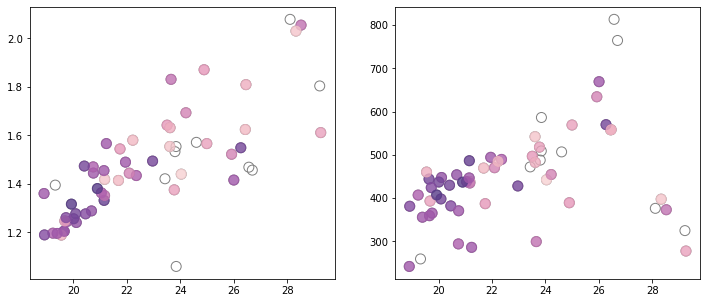

In [160]:
pheno=84

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().vpd,
            facecolor='none', edgecolor='grey',s=100)
ax1.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().vpd,
            alpha=0.8, s=100, c=mx_present[pheno], cmap=PurpOr_6.mpl_colormap.reversed(), vmax=20)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            facecolor='none', edgecolor='grey',s=100)
ax2.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            alpha=0.8, s=100, c=mx_present[pheno], cmap=PurpOr_6.mpl_colormap.reversed(), vmax=20)

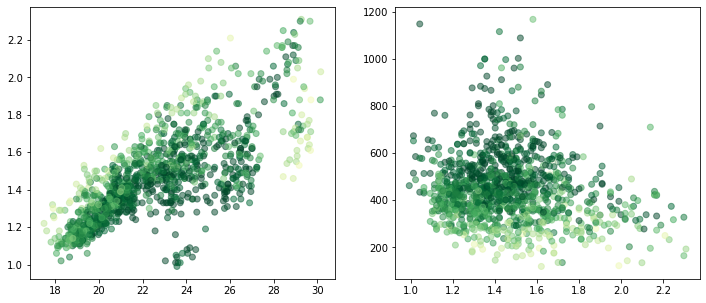

In [174]:
pheno=4
df_ear_pheno = df_all.query(f'cvar=={pheno}')[['year', 'site', 'dm_ear']]
df = df_ear_pheno.merge(df_wea, on=['site','year'])

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df.temp, df.vpd, c=df.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.5, vmax=240)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df.vpd, df.precip, c=df.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.5, vmax=240)

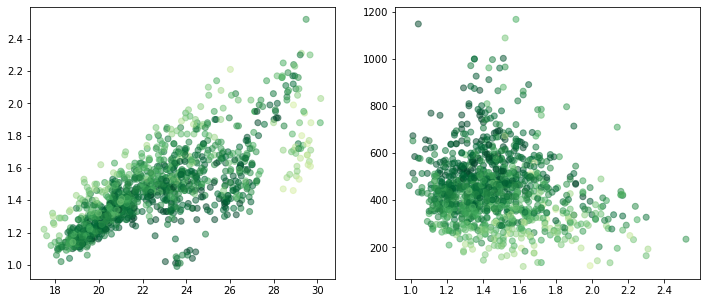

In [173]:
pheno=62
df_ear_pheno = df_all.query(f'cvar=={pheno}')[['year', 'site', 'dm_ear']]
df = df_ear_pheno.merge(df_wea, on=['site','year'])

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df.temp, df.vpd, c=df.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.5, vmax=200)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df.vpd, df.precip, c=df.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.5, vmax=200)
#ax2.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
#            facecolor='none', edgecolor='grey',s=100)
#ax2.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
#            alpha=0.8, s=100, c=mx_present[pheno], cmap=PurpOr_6.mpl_colormap.reversed(), vmax=20)

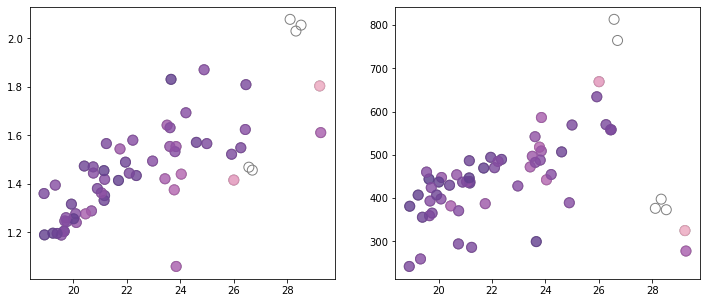

In [133]:
pheno=4

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().vpd,
            facecolor='none', edgecolor='grey',s=100)
ax1.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().vpd,
            alpha=0.8, s=100, c=mx_f2100[pheno], cmap=PurpOr_6.mpl_colormap.reversed(), vmax=20)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            facecolor='none', edgecolor='grey',s=100)
ax2.scatter(df_wea.groupby('site').mean().temp, df_wea.groupby('site').mean().precip,
            alpha=0.8, s=100, c=mx_f2100[pheno], cmap=PurpOr_6.mpl_colormap.reversed(), vmax=20)

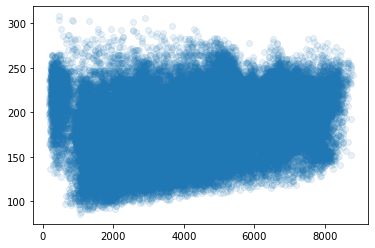

In [39]:
df_leaves_matured = df_leaves[df_leaves.pheno=='"grainFill"']
test = df_leaves_matured.merge(df_pheno_gf, on=['cvar','site','year'])
plt.scatter(test.LA, test.jday, alpha=0.1)

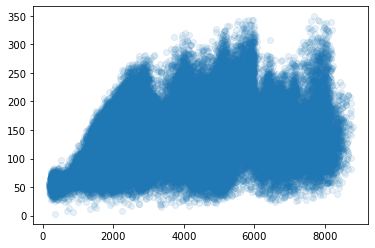

In [40]:
#df_all.site = df_all.site.astype(int)
df_leaves_matured = df_leaves[df_leaves.pheno=='"grainFill"']
test = df_leaves_matured.merge(df_all, on=['cvar','site','year'])
#plt.scatter(test.query('cvar==4').LA_x, test.query('cvar==4').dm_ear, alpha=0.5)
plt.scatter(test.LA_x, test.dm_ear, alpha=0.1)

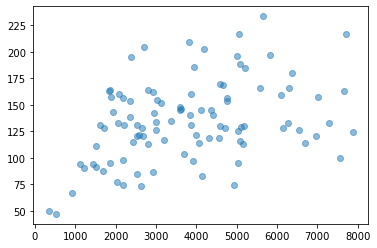

In [41]:
dm_ears = df_all.groupby('cvar').mean().dm_ear.reindex(phenos_ranked)
plt.scatter(LA, dm_ears, alpha=0.5)

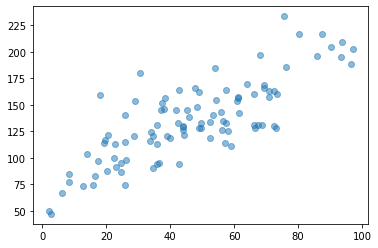

In [42]:
plt.scatter(gf_lengths, dm_ears, alpha=0.5)

## Performance in map

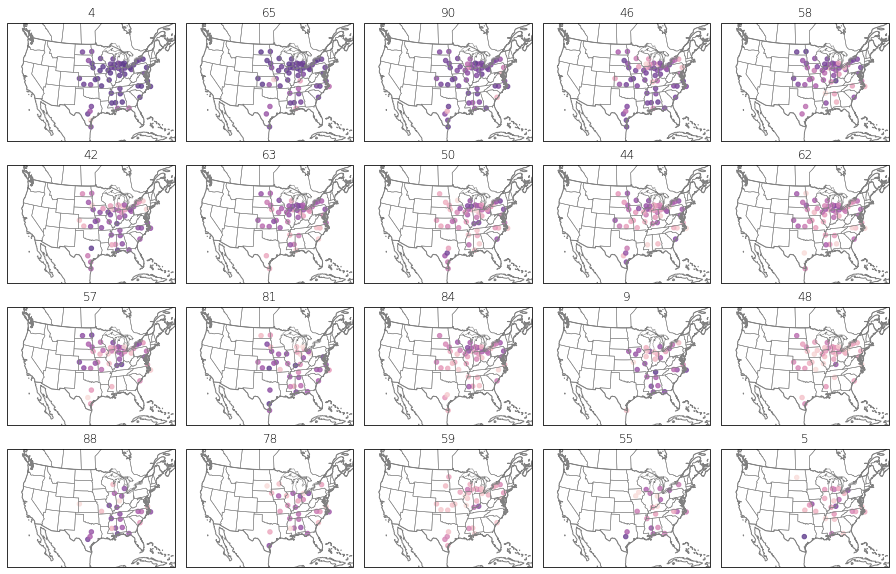

In [128]:
# Identify top phenos
df_pheno, mx = identify_top_phenos('present',20,1,1)
top_phenos = rank_top_phenos('present',20,1,1)

# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_phenos[:20]):
    ax = fig.add_subplot(4,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(),
                    c = mx[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
                    vmin=0, vmax=20, alpha=0.8, s=20)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(pheno, fontweight='light')

fig.subplots_adjust(wspace=0)
    
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_top_pheno_ranking.png', format='png', dpi=800)

In [39]:
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

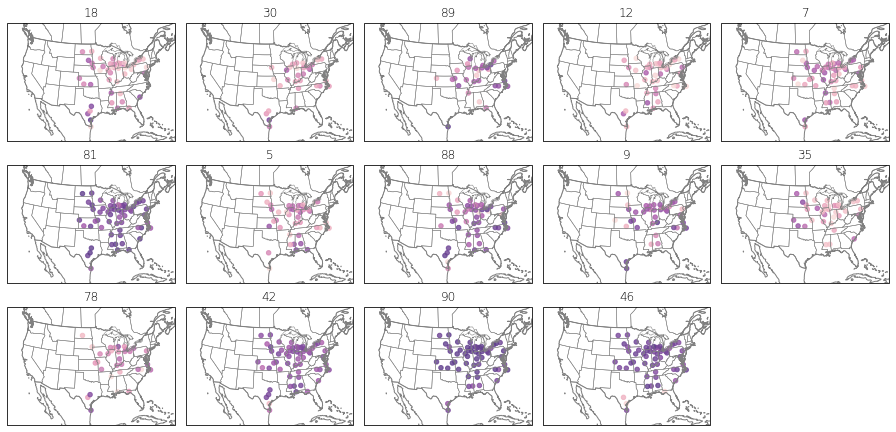

In [38]:
# Identify improved phenos under future climate
phenos_improved, phenos_targeted, phenos_new = identify_improved_phenos(20, 1, 1, 'f2100', 20)

# Identify pheno rankings under future climate sims
df_pheno, mx = identify_top_phenos('f2100', 20, 1, 1)

# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(phenos_targeted):
    ax = fig.add_subplot(4,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(),
                    c = mx[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
                    vmin=0, vmax=20, alpha=0.8, s=20)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(pheno, fontweight='light')

fig.subplots_adjust(wspace=0)